In [28]:
'''Predicting Mortality across Germany wih different AI Methods
'''

import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
import dbf
from pygam import GAM, s, f, LinearGAM
import xgboost
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data

In [30]:
# Set the working directory
os.chdir("N:/WG_ENRI/20_projects/Noise2NAKO/04_data/grid_prediction/3_output")
grid_path = "N:/PROJECTS/ENVGEO_DB/1_GIS_data_orig/2_administrative_units/BKG/INSPIRE_geogitter/DE_Grid_ETRS89-LAEA/data/DE_Grid_ETRS89-LAEA_5km.gpkg"

In [4]:
# Read training and test data
data_training = pd.read_csv('Prediction/Training_data_cvd_noise.csv', sep=',')
data_test = pd.read_csv('Prediction/Test_data_cvd_noise.csv', sep=',')

In [5]:
# distinguish between response and input variables and make training and test data 
# remove unnecessary features 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'

output_variable = 'cvd_mortality_17'
output_path = 'CVD Mortality Rate 2017 incl Noise_XY'

# output_variable = 'ks_Mortality_17'
# output_path = 'Total Mortality Rate 2017 incl XY'

output_path = '../5_results/' + output_path + '/'
coord = True

y = data_training[output_variable]
if coord:
    X = data_training.drop([output_variable, 'ks_Mortality_17', 'id'], axis = 1)   
else:
    X = data_training.drop([output_variable, 'ks_Mortality_17', 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'], axis = 1)
    
pred_y = data_test[output_variable]
if coord:
    pred_X = data_test.drop([output_variable, 'ks_Mortality_17', 'id'], axis = 1)
else:
    pred_X = data_test.drop([output_variable, 'ks_Mortality_17', 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# Prediction

In [35]:
def Prediction(method, X_train, X_test, y_train, y_test, pred_X, pred_y, output_variable, output_path, data_training, data_test, grid_5km_shp):
    
    '''Prediction Function'''
    
    if method == 'LR':
        model = linear_model.LinearRegression().fit(X_train, y_train)
    elif method == 'LR_Ridge':
        model = linear_model.RidgeCV(cv = 5).fit(X_train, y_train)
    elif method == 'LR_Lasso':
        model = linear_model.LassoCV(cv = 5, random_state=0).fit(X_train, y_train)
    elif method == 'LR_Elastic':
        model = linear_model.ElasticNetCV(cv = 5, random_state=0).fit(X_train, y_train)
    elif method == 'GAM':
        model = GAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9)).fit(X_train, y_train)
    elif method == 'RF':
        model = RandomForestRegressor(n_estimators= 10, max_depth= 10, random_state= 0, max_features='sqrt').fit(X_train, y_train)
    elif method == 'AdaB':
        model = AdaBoostRegressor(n_estimators= 10, random_state=0).fit(X_train, y_train)
    else:
        model = xgboost.XGBRegressor().fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred = model.predict(pred_X)
    y_pred = pd.DataFrame(y_pred, columns = [output_variable])

    result = {'Method': method, 'MSE_train': mean_squared_error(y_train, y_pred_train),
                            'MAE_train': mean_absolute_error(y_train, y_pred_train), 'R_2_train': r2_score(y_train, y_pred_train),
                           'MSE_val': mean_squared_error(y_test, y_pred_test), 'MAE_val': mean_absolute_error(y_test, y_pred_test),
                           'R_2_val': r2_score(y_test, y_pred_test), 'MSE_pred': mean_squared_error(pred_y, y_pred), 'MAE_pred': mean_absolute_error(pred_y, y_pred),
                           'R_2_pred': r2_score(pred_y, y_pred)}
    
#     Merge dataframes to make the final output dataset 
    data_result= pd.DataFrame()
    data_result = data_result.append(data_training)
    data_result = data_result.append(pd.concat([data_test.drop([output_variable], axis = 1),pd.DataFrame(y_pred)],axis=1))
    data_result = data_result[['id', output_variable]]
    data_result.to_csv((output_path + 'prediction_result_'+method+'.csv'), sep=',', index=False)
    
#     Merge dataframes to make the Ground Truth
    data_result= pd.DataFrame()
    data_result = data_result.append(data_training)
    data_result = data_result.append(pd.concat([data_test.drop([output_variable], axis = 1),pd.DataFrame(pred_y)],axis=1))
    data_result = data_result[['id', output_variable]]
    data_result.to_csv((output_path + method + '/prediction_result_' + method + '.csv'), sep=',', index=False)
    
    
#     Make the difference output
    data_diff_result= pd.DataFrame()
    data_diff_result = data_diff_result.append(data_training)
    data_diff_result[output_variable] = 0
    pred_variable = 'pred'+output_variable
    data_test = pd.concat([data_test, y_pred.rename(columns={output_variable: pred_variable})], axis=1)
    data_test[output_variable] = data_test[output_variable] - data_test[pred_variable]
    data_diff_result = data_diff_result.append(data_test.drop([pred_variable], axis = 1))
    data_diff_result = data_diff_result[['id', output_variable]]
    data_diff_result.to_csv((output_path + 'diff_' + method + '/prediction_result_diff_' + method + '.csv'), sep=',', index=False)
    
#     Make shp files
    merged_data = grid_5km_shp.merge(data_result, left_on="id", right_on="id")
    merged_data_diff = grid_5km_shp.merge(data_diff_result, left_on="id", right_on="id")
#     save the GeoDataFrame
    merged_data.to_file(driver = 'ESRI Shapefile', filename= output_path + method + '/' + method + '_shape.shp')
    merged_data_diff.to_file(driver = 'ESRI Shapefile', filename= output_path + 'diff_'+ method + '/diff_' + method + '_shape.shp')
    
    return result, y_pred

### Prediction with different methods

In [36]:
result = pd.DataFrame(columns=['Method', 'MSE_train', 'MAE_train', 'R_2_train', 'MSE_val', 'MAE_val', 'R_2_val', 'MSE_pred', 'MAE_pred', 'R_2_pred'])
methods = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'RF', 'AdaB', 'XGBoost']
preds = pd.DataFrame()
preds['GT'] = pred_y

grid_5km_shp = gpd.read_file(grid_path)

for i in methods:
    ToAppend, y_pred = Prediction(i, X_train, X_test, y_train, y_test, pred_X, pred_y, output_variable,
                                 output_path, data_training, data_test, grid_5km_shp)
    result = result.append(ToAppend, ignore_index=True)
    preds[i] = y_pred
    
result.to_csv(output_path + 'PredictionTask_results_alMethods.csv', index=False, sep=',')
result.round(decimals=3).to_csv(output_path + 'PredictionTask_results_alMethods_round.csv', index=False, sep=',')

result

,Method,MSE_train,MAE_train,R_2_train,MSE_val,MAE_val,R_2_val,MSE_pred,MAE_pred,R_2_pred
0,LR,0.109875,0.239581,0.895079,0.098786,0.223477,0.903112,0.506337,0.540181,0.499332
1,LR_Ridge,0.110552,0.240676,0.894433,0.100105,0.227555,0.901819,0.520690,0.551779,0.485140
2,LR_Lasso,0.518194,0.589722,0.505173,0.463448,0.570030,0.545459,0.862006,0.685550,0.147645
3,LR_Elastic,0.518198,0.589725,0.505169,0.463451,0.570032,0.545457,0.862007,0.685550,0.147644
4,GAM,0.019731,0.088177,0.981159,0.029679,0.106747,0.970892,0.470500,0.507509,0.534768
5,RF,0.009992,0.050354,0.990458,0.032427,0.097554,0.968197,0.436365,0.502720,0.568521
6,AdaB,0.048115,0.157629,0.954055,0.063676,0.175032,0.937548,0.478524,0.531680,0.526834
7,XGBoost,0.000002,0.000940,0.999998,0.013894,0.055238,0.986373,0.397873,0.474731,0.606581


In [9]:
preds

,GT,LR,LR_Ridge,LR_Lasso,LR_Elastic,GAM,RF,AdaB,XGBoost
0,4.0,4.214250,4.168707,3.748045,3.748019,3.332389,3.854787,3.645864,3.413845
1,4.0,4.267438,4.220548,3.880637,3.880587,3.247505,3.774787,3.645864,3.420081
2,4.0,4.149975,4.105235,3.665267,3.665258,3.378129,3.616182,3.645864,3.539855
3,4.0,4.187910,4.141554,3.742732,3.742710,3.335923,3.797093,3.645864,3.468265
4,4.0,4.122639,4.075496,3.701977,3.701968,3.293246,3.610001,3.645864,3.522094
...,...,...,...,...,...,...,...,...,...
13840,4.2,5.191663,5.083431,5.257739,5.257689,4.149575,4.551020,5.268529,5.130966
13841,4.2,5.207567,5.097858,5.170635,5.170605,4.230724,4.606704,5.268529,5.117471
13842,4.2,5.297150,5.192468,5.151300,5.151276,4.227047,4.606704,5.268529,5.119306
13843,4.2,5.078292,4.974613,5.267770,5.267721,4.301316,4.800096,5.268529,5.113612


<Figure size 432x288 with 0 Axes>

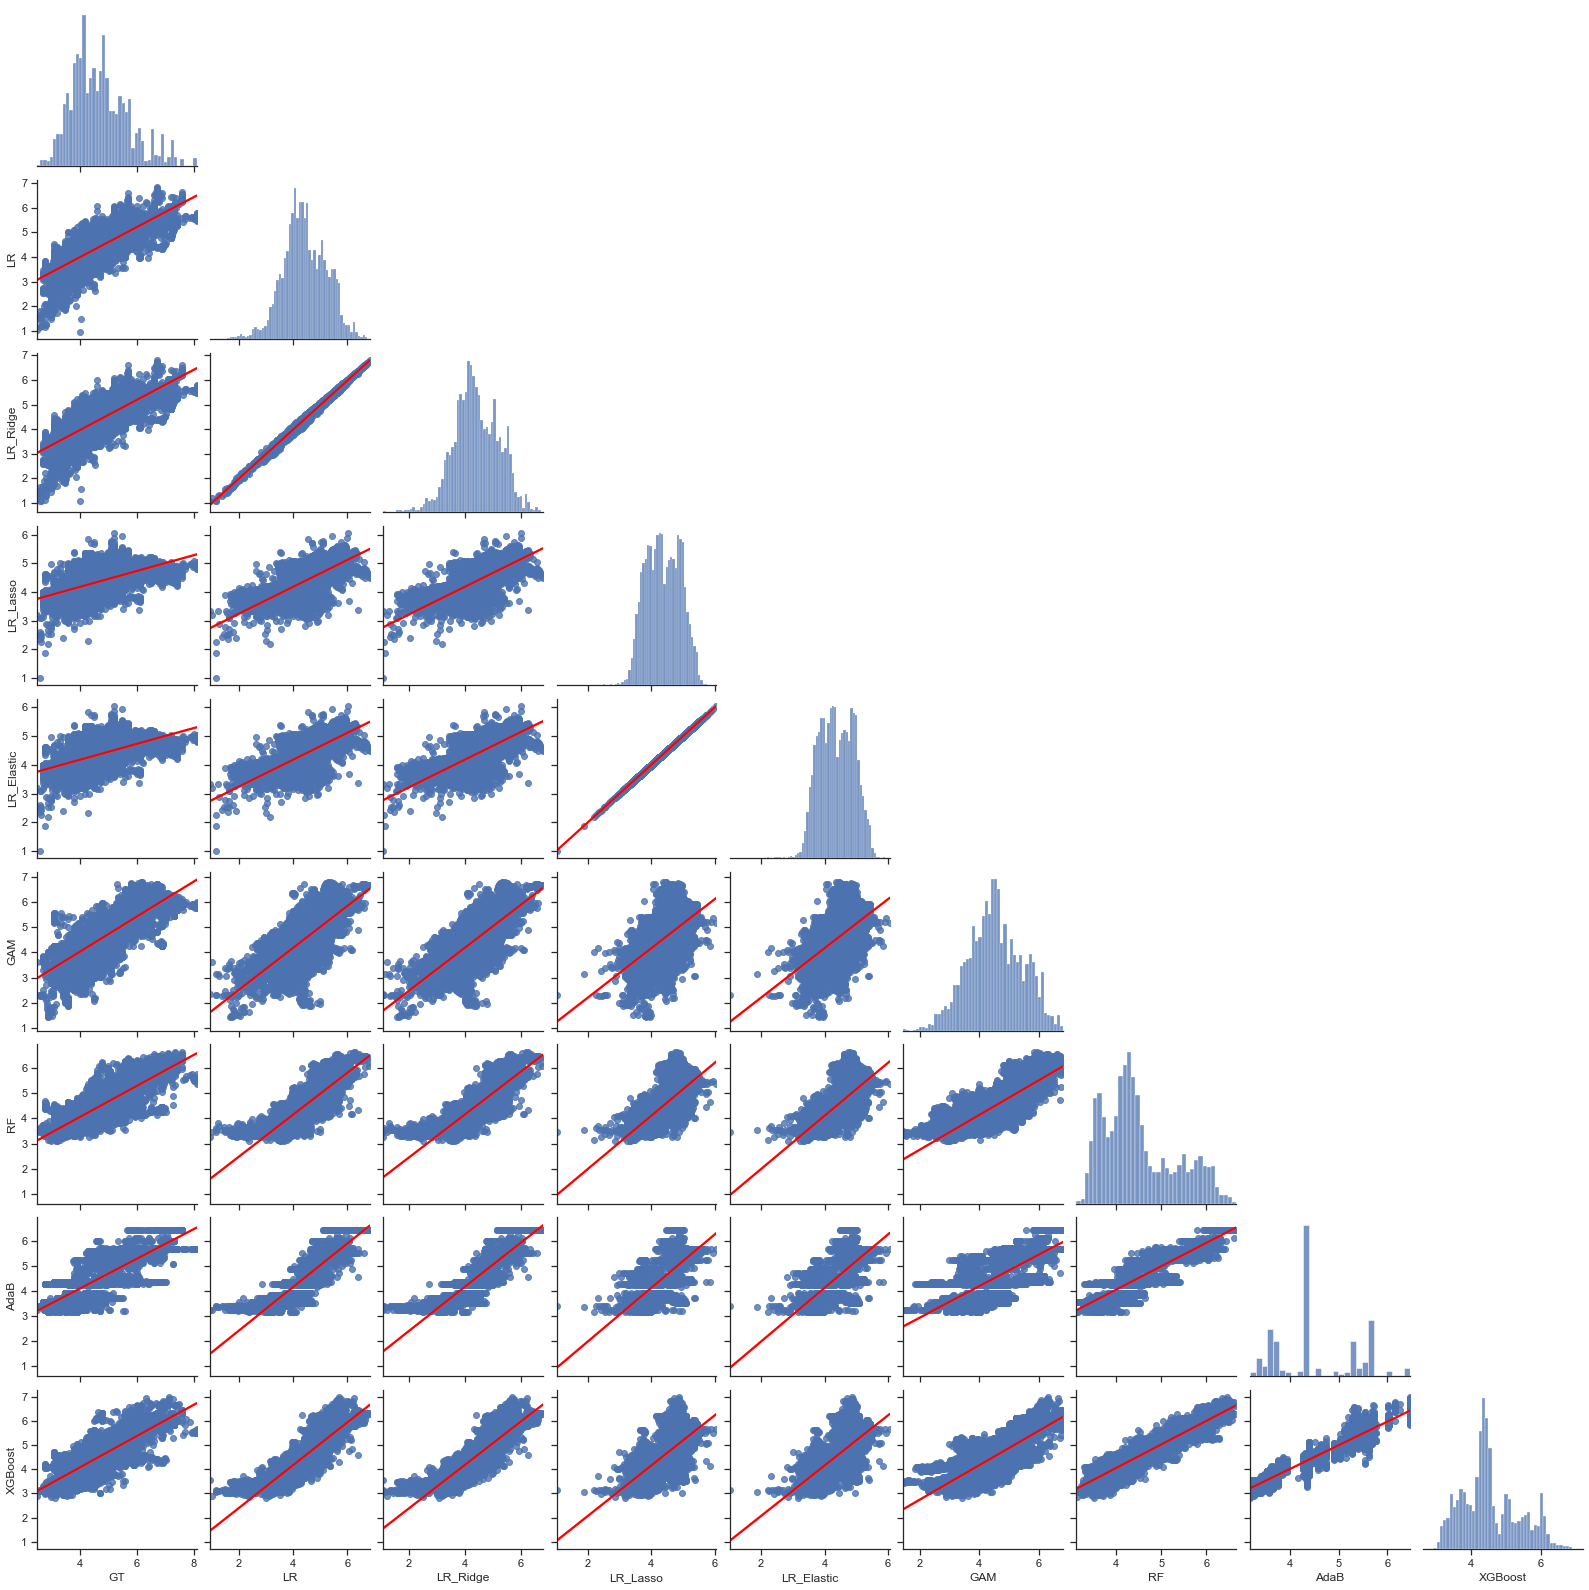

In [18]:
plt.figure()
sns.set(style="ticks", color_codes=True)
sns.pairplot(preds, corner=True, kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.savefig('Plots/Performance_correlation')

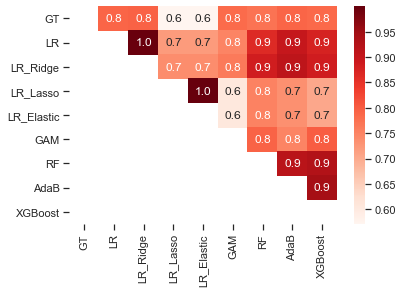

In [16]:
correlation_matrix = preds.corr(method='spearman')
upper_corr_matrix = np.tril(correlation_matrix)
plt.figure()
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Reds', mask = upper_corr_matrix )
plt.savefig('Plots/Performance_correlation_Heatmap')

<Figure size 432x288 with 0 Axes>

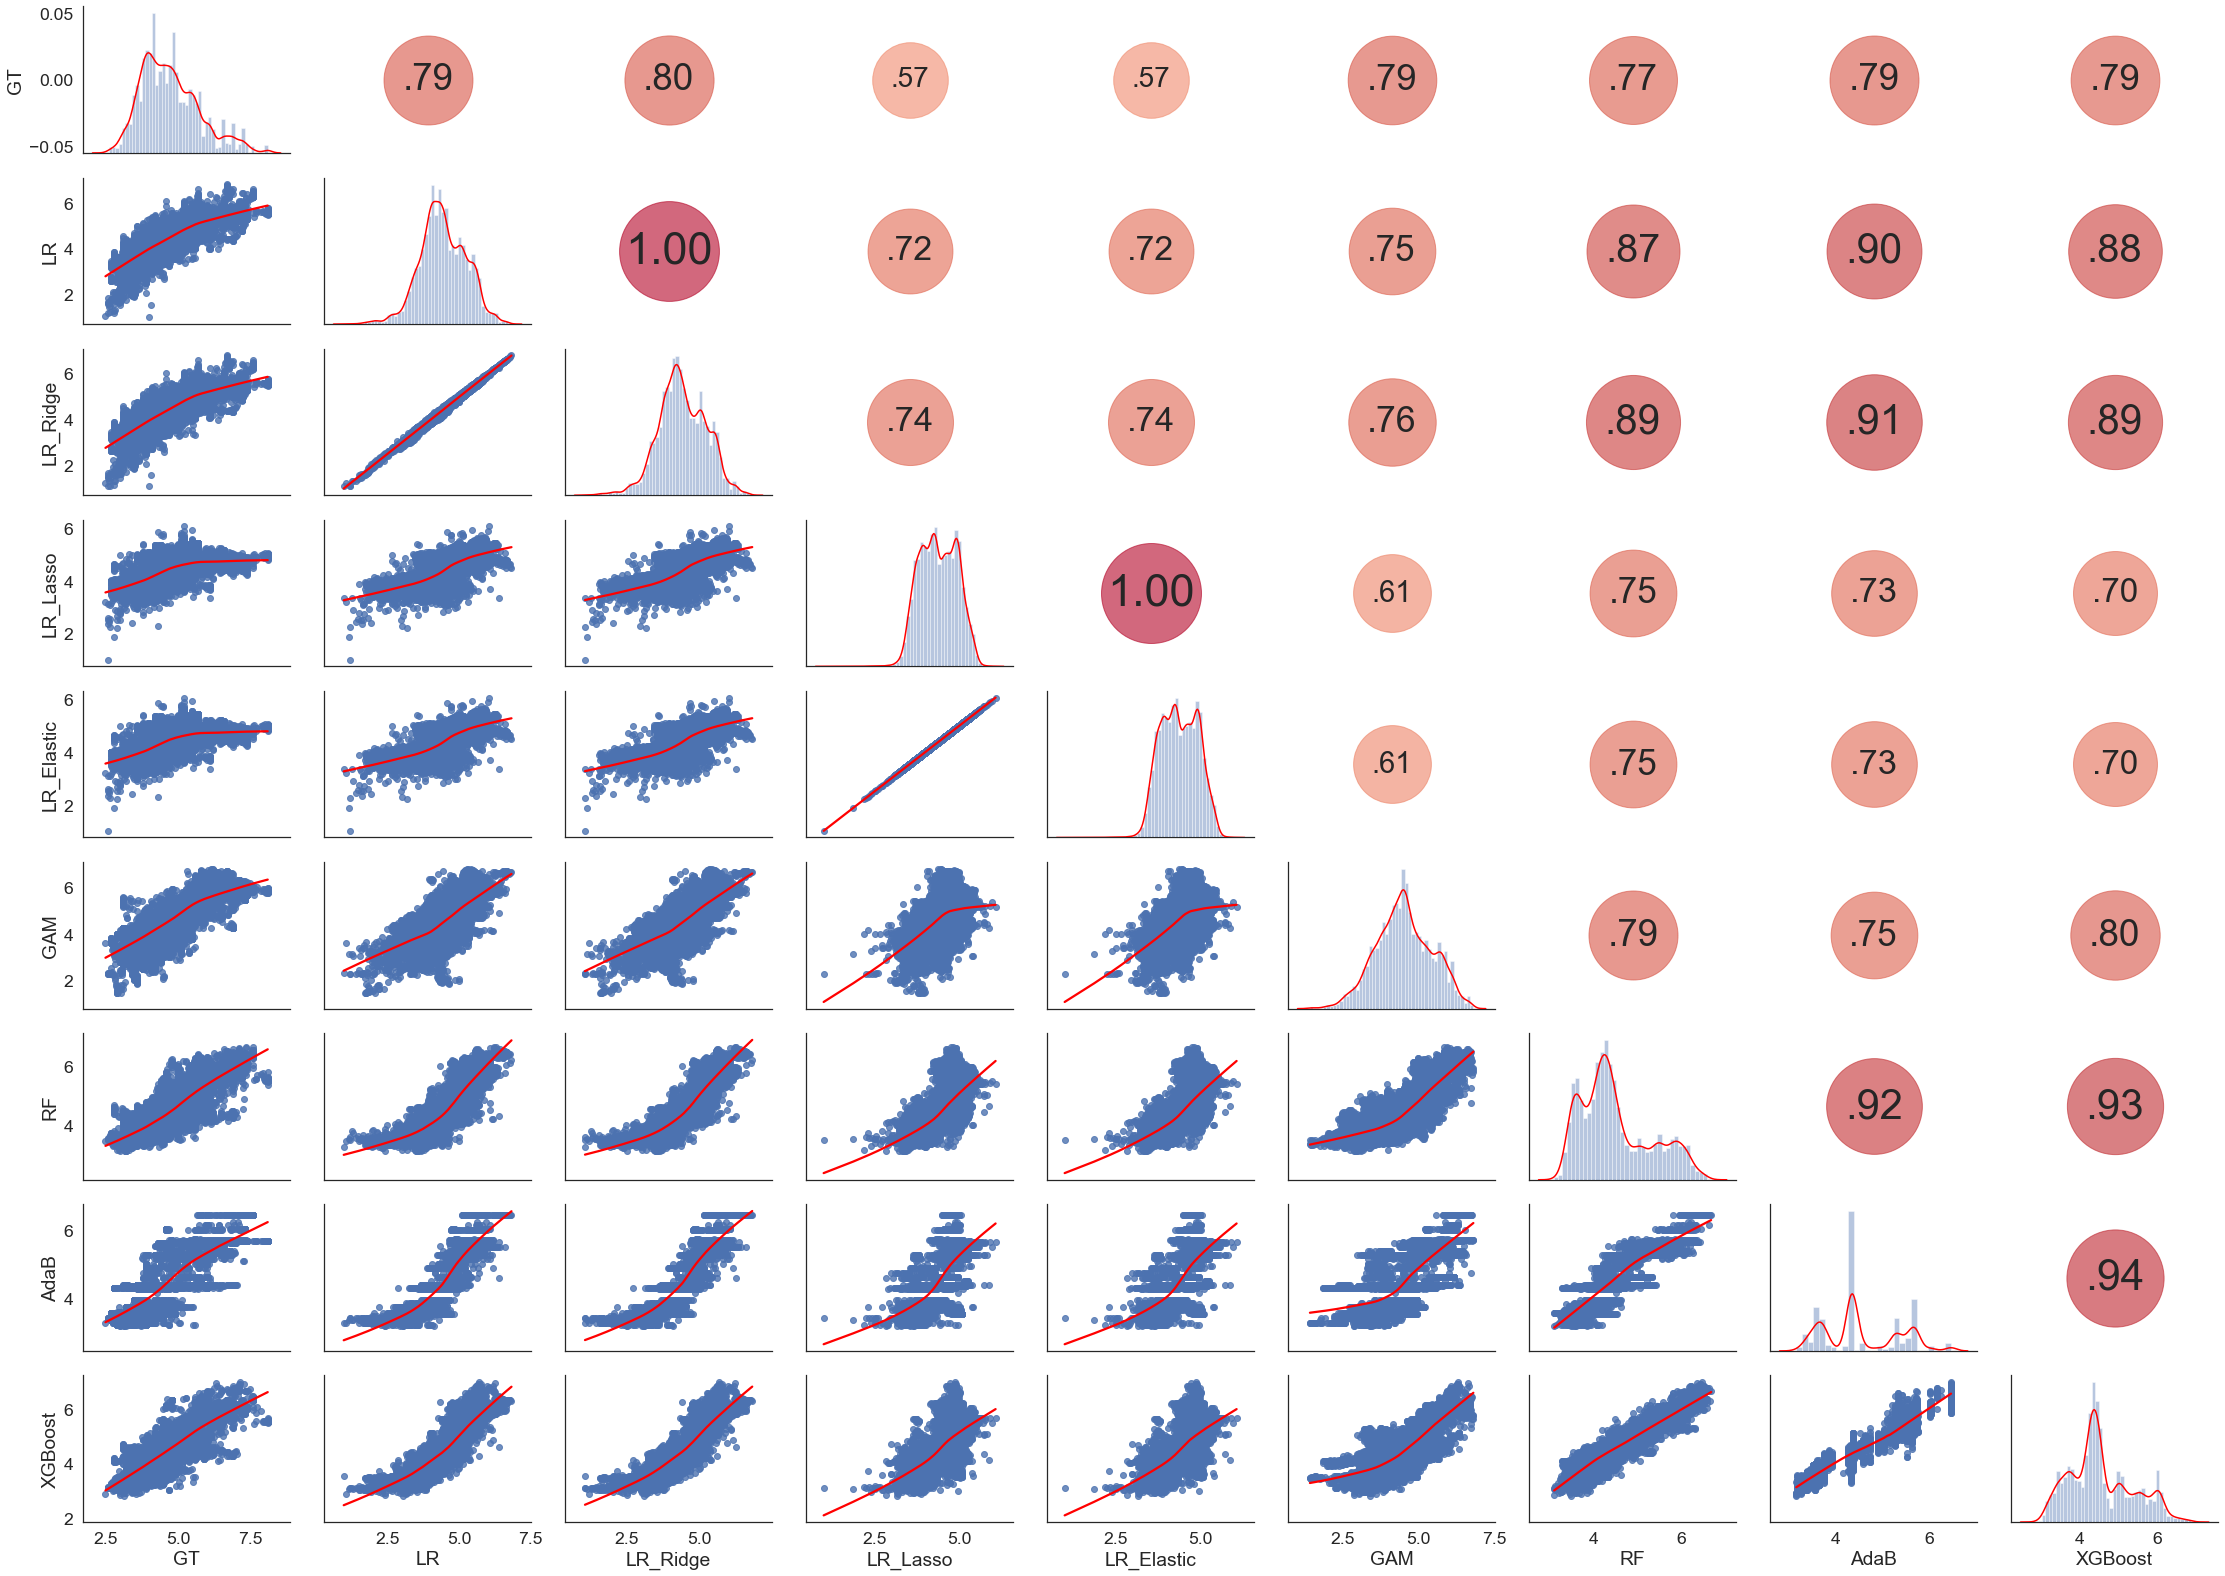

In [21]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
plt.figure()
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(preds, aspect=1.4, diag_sharey=False)
#g.map_lower(sns.regplot, lowess=True, ci=True, line_kws={'color': 'red'})
g.map_lower(sns.regplot, scatter_kws={'s':10}, line_kws={'color': 'red'})
g.map_diag(sns.distplot, kde_kws={'color': 'red'})
g.map_diag(annotate_colname)
g.map_upper(corrdot)

plt.savefig('Plots/scatter_corr')